# Tasck

**Описание задания:**

В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.

Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

**Этапы работы:**

Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

a) Для отображения картинки воспользуйтесь вспомогательной функцией:

import matplotlib.pyplot as plt

import cv2

import skimage

def draw_picture(image, title, bgr=False):

b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB

new_image = cv2.merge([r, g, b])

plt.figure(figsize=(7, 5))

plt.axis(‘off’)

plt.imshow(new_image)

plt.title(title)

plt.show()

b) Для загрузки картинки можно использовать код:

img = cv.imread(path)

Реализуйте три модели кластеризации:

a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.

b) DBSCAN

c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

Сформулируйте выводы по проделанной работе.

a) Какая модель показала лучший результат?

Для получения зачета по этому домашнему заданию минимально должно быть реализовано обучение трех моделей с одним и тем же значением кластеров, где такой параметр присутствует.

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim

In [2]:
SEED = 42
K = [2, 5, 10, 20]
EPS = [0.1, 1, 2, 3]

In [3]:
def draw_picture(image: np.array, title: str='Picture', bgr: bool=False) -> None:
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

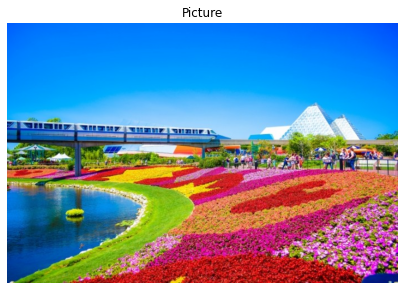

In [4]:
image = cv2.imread('YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg')
draw_picture(image)

# Kmeans

## Variant 1
https://www.machinelearningmastery.ru/introduction-to-image-segmentation-with-k-means-clustering-83fd0a9e2fc3/

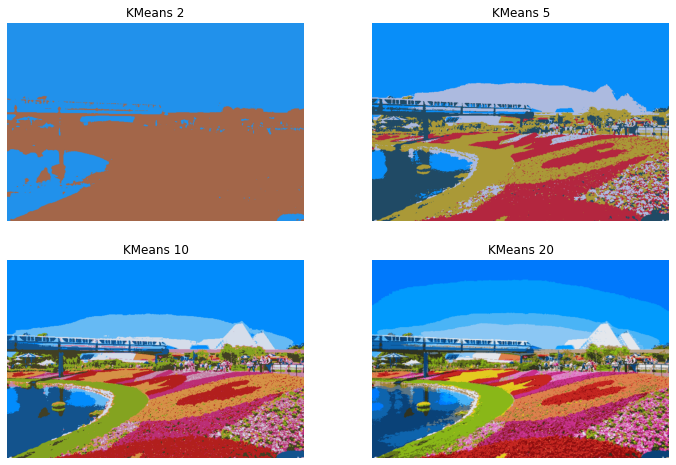

In [5]:
pic_box = plt.figure(figsize=(12,8))
vectorized = np.float32(image.reshape((-1,3)))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts=10

for i, k in enumerate(K):
    ret,label,center = cv2.kmeans(data=vectorized, K=k, bestLabels=None, criteria=criteria, 
                                attempts=attempts, flags=cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    result_image = center[label.flatten()].reshape((image.shape))
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    pic_box.add_subplot(2,2,i+1)
    plt.imshow(result_image)
    plt.title(f'KMeans {k}')
    plt.axis('off')
    # break

## Variant 2

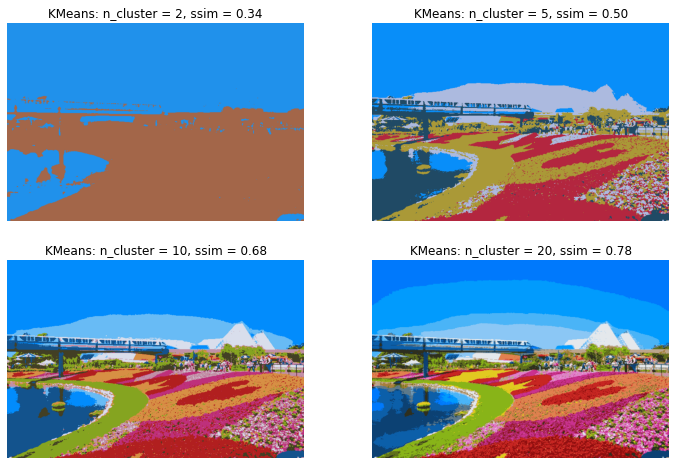

In [6]:
pic_box = plt.figure(figsize=(12,8))
vectorized = np.float32(image.reshape((-1,3)))
for i, k in enumerate(K):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(vectorized)
    result = np.uint8(kmeans.cluster_centers_)[kmeans.labels_]
    result_img = result.reshape(image.shape)
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    ssim_value = ssim(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                      result_img, 
                      data_range=result_img.max() - result_img.min(), 
                      multichannel=True)
    pic_box.add_subplot(2,2,i+1)
    plt.imshow(result_img)
    plt.title(f'KMeans: n_cluster = {k}, ssim = {ssim_value:.2f}')
    plt.axis('off')

# DBSCAN

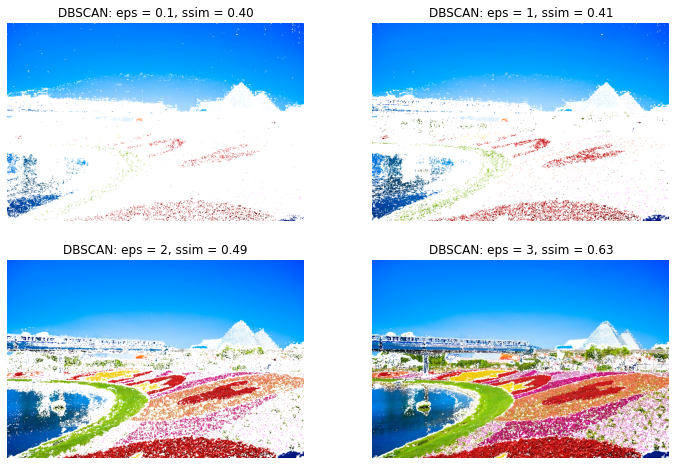

In [7]:
pic_box = plt.figure(figsize=(12,8))
vectorized = np.float32(image.reshape((-1,3)))

for i, eps in enumerate(EPS):
    dbscan = DBSCAN(eps=eps, min_samples=5).fit(vectorized)
    result = []
    for cnt, j in enumerate(dbscan.labels_):
        if j == -1:
            result.append([255, 255, 255])
        else:
            result.append(vectorized[cnt])
    result = np.uint8(np.array(result))

    result_img = result.reshape(image.shape)
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    ssim_value = ssim(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                    result_img, 
                    data_range=result_img.max() - result_img.min(), 
                    multichannel=True)
    pic_box.add_subplot(2,2,i+1)
    plt.imshow(result_img)
    plt.title(f'DBSCAN: eps = {eps}, ssim = {ssim_value:.2f}')
    plt.axis('off')

# AgglomerativeClustering

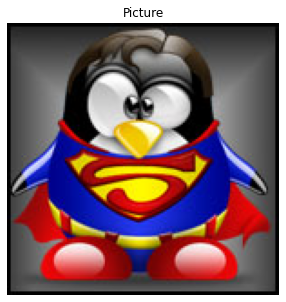

In [11]:
image = cv2.imread('38.jpg')
draw_picture(image)

In [9]:
def mean_color(labels: np.array, colors: np.array) -> dict:
    mean_colors = {}
    for label in np.unique(labels):
        mean_colors[label] = [round(i.mean()) for i in colors[labels==label].T]
    return mean_colors

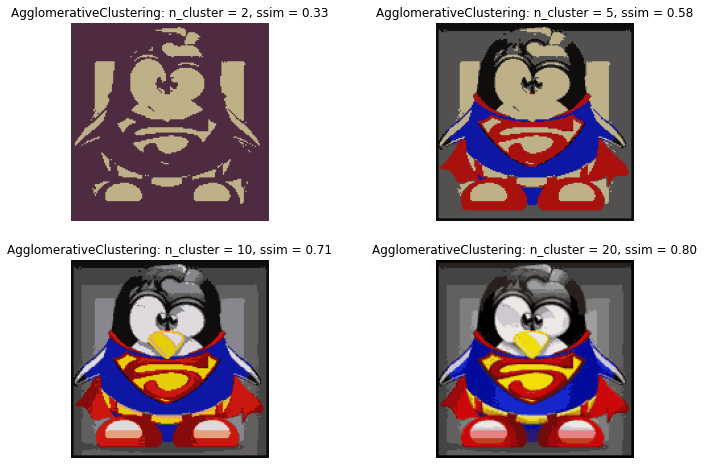

In [12]:
pic_box = plt.figure(figsize=(12,8))
vectorized = np.float16(image.reshape((-1,3)))

for i, k in enumerate(K):
    agg_clust = AgglomerativeClustering(n_clusters=k).fit(vectorized)
    clustering_color = mean_color(agg_clust.labels_, vectorized)

    result = []
    for label in agg_clust.labels_:
        result.append(clustering_color[label])
    result = np.uint8(np.array(result))

    result_img = result.reshape(image.shape)
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    ssim_value = ssim(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                result_img, 
                data_range=result_img.max() - result_img.min(), 
                multichannel=True)
    pic_box.add_subplot(2,2,i+1)
    plt.imshow(result_img)
    plt.title(f'AgglomerativeClustering: n_cluster = {k}, ssim = {ssim_value:.2f}')
    plt.axis('off')

# Resume

a) Сравнивать плотностные алгоритмы с метрическими в данной ситуации, на мой вгляд, не совсем корректно. Итоговый вид изображения по структуре разный.

Обратил внимание на то, что иерархическая кластеризация требовательна к опеативной памяти (из-за этого пришлось сменить изображение на меньшего разрешения)
